In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping



In [29]:
from google.colab import files
uploaded = files.upload()


Saving final_store_train_data.csv to final_store_train_data (1).csv


In [30]:
train = pd.read_csv("final_store_train_data.csv")

train['Date'] = pd.to_datetime(train['Date'])
train = train.sort_values('Date')

daily_sales = train.groupby('Date')['Sales'].sum()



In [31]:
scaler = MinMaxScaler(feature_range=(0,1))

scaled_data = scaler.fit_transform(
    daily_sales.values.reshape(-1,1)
)


In [32]:
def create_sequences(data, window_size=30):
    X, y = [], []

    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])

    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(scaled_data, window_size)


In [33]:
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Training Shape:", X_train.shape)
print("Testing Shape:", X_test.shape)


Training Shape: (729, 30, 1)
Testing Shape: (183, 30, 1)


In [34]:
model = Sequential()

model.add(LSTM(64, return_sequences=True, input_shape=(window_size, 1)))
model.add(Dropout(0.2))

model.add(LSTM(64))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.1080 - val_loss: 0.0586
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0518 - val_loss: 0.0585
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0549 - val_loss: 0.0604
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0556 - val_loss: 0.0587
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0531 - val_loss: 0.0595
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0545 - val_loss: 0.0575
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0543 - val_loss: 0.0573
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0533 - val_loss: 0.0584
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0554 - val_loss: 0.0582
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0521 - val_loss: 0.0582
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0554 - val_loss: 0.0605
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0

In [36]:
y_pred_scaled = model.predict(X_test)

# Convert back to original scale
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


In [37]:
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
r2 = r2_score(y_test_actual, y_pred)

print("Test RMSE:", round(rmse, 2))
print("Test R2 Score:", round(r2, 4))


Test RMSE: 3164057.47
Test R2 Score: 0.0029


In [38]:
future_steps = 42
future_predictions = []

last_sequence = scaled_data[-window_size:]

for _ in range(future_steps):
    pred = model.predict(last_sequence.reshape(1, window_size, 1))
    future_predictions.append(pred[0][0])

    last_sequence = np.append(last_sequence[1:], pred)
    last_sequence = last_sequence.reshape(-1,1)

# Convert back to original scale
future_predictions = scaler.inverse_transform(
    np.array(future_predictions).reshape(-1,1)
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━

In [39]:
future_dates = pd.date_range(
    start=daily_sales.index[-1] + pd.Timedelta(days=1),
    periods=future_steps,
    freq='D'
)

future_df = pd.DataFrame({
    "Date": future_dates,
    "Forecasted_Sales": future_predictions.flatten()
})

print(future_df.head())


        Date  Forecasted_Sales
0 2015-08-01         5848965.0
1 2015-08-02         5836170.0
2 2015-08-03         5868225.0
3 2015-08-04         5924953.0
4 2015-08-05         5990193.0


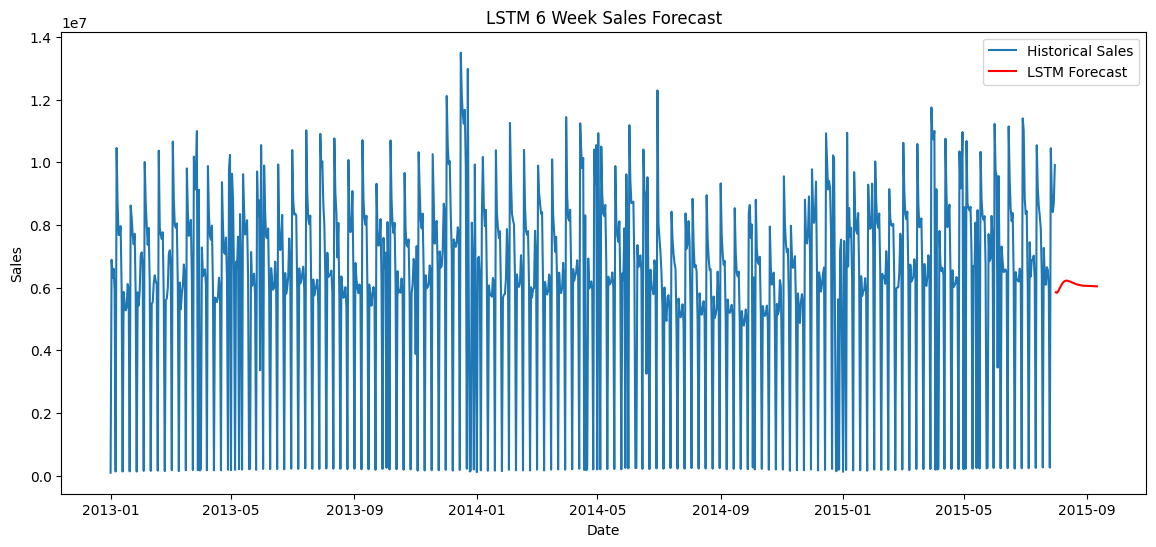

In [40]:
plt.figure(figsize=(14,6))

plt.plot(daily_sales, label="Historical Sales")
plt.plot(future_dates, future_predictions,
         color="red", label="LSTM Forecast")

plt.title("LSTM 6 Week Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


In [41]:
future_df.to_csv("lstm_6_week_forecast.csv", index=False)

print("LSTM Forecast saved successfully!")


LSTM Forecast saved successfully!
